In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np
import seaborn as sns

In [2]:
chr="NW_022145594.1"
start=39429440
stop=42445994

snps=pd.read_csv(f"/netfiles/pespenilab_share/urchin_bcfs/{chr}/{chr}_filtered.vcf", sep="\t",comment='#',header=None)
df=pd.read_csv(f'nuc_div_data/{chr}_nuc_div.windowed.pi',sep="\t")
df = df.dropna()

/users/c/p/cpetak/miniconda3/envs/wgs/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


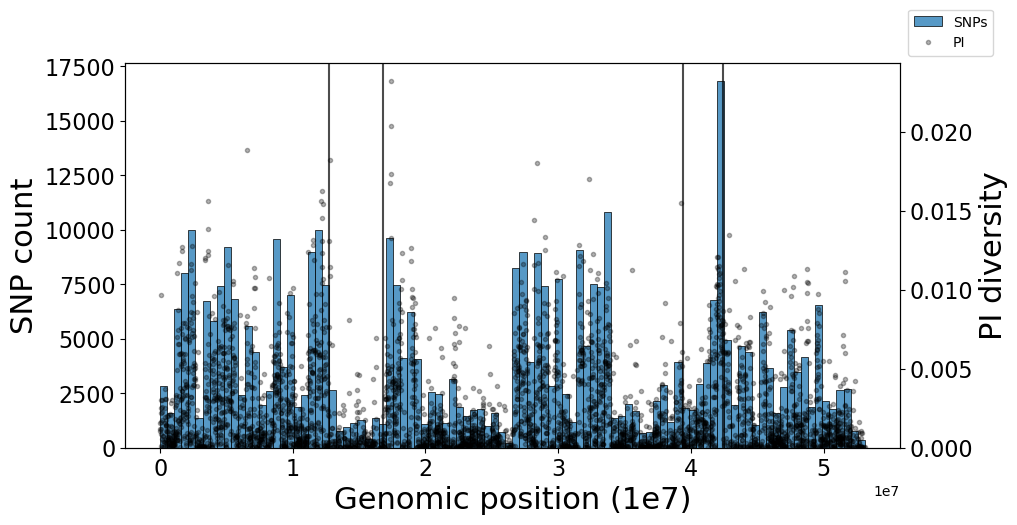

In [3]:
fig, ax1 = plt.subplots(figsize=(10, 5))

sns.histplot(snps.iloc[:,1].to_list(),bins=100,ax=ax1,label="SNPs")

ax1.set_ylabel("SNP count", fontsize=22)
ax1.set_xlabel("Genomic position (1e7)", fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_ylim(0, None) 

# Create the second plot with a different y-axis
ax2 = ax1.twinx()
ax2.plot(df["BIN_START"],df["PI"],".",color="black",alpha=0.3,label="PI")
ax2.set_ylabel("PI diversity", fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_ylim(0, None) 

# Labels and legend
fig.legend( loc='upper right', bbox_to_anchor=(1, 1))

plt.axvline(start, color="black",alpha=0.7)
plt.axvline(stop, color="black",alpha=0.7)  
plt.axvline(12702886, color="black",alpha=0.7)
plt.axvline(16793794, color="black",alpha=0.7)

plt.savefig("intermediary_files/fig5_diversity.pdf", format='pdf', bbox_inches='tight')

plt.show()

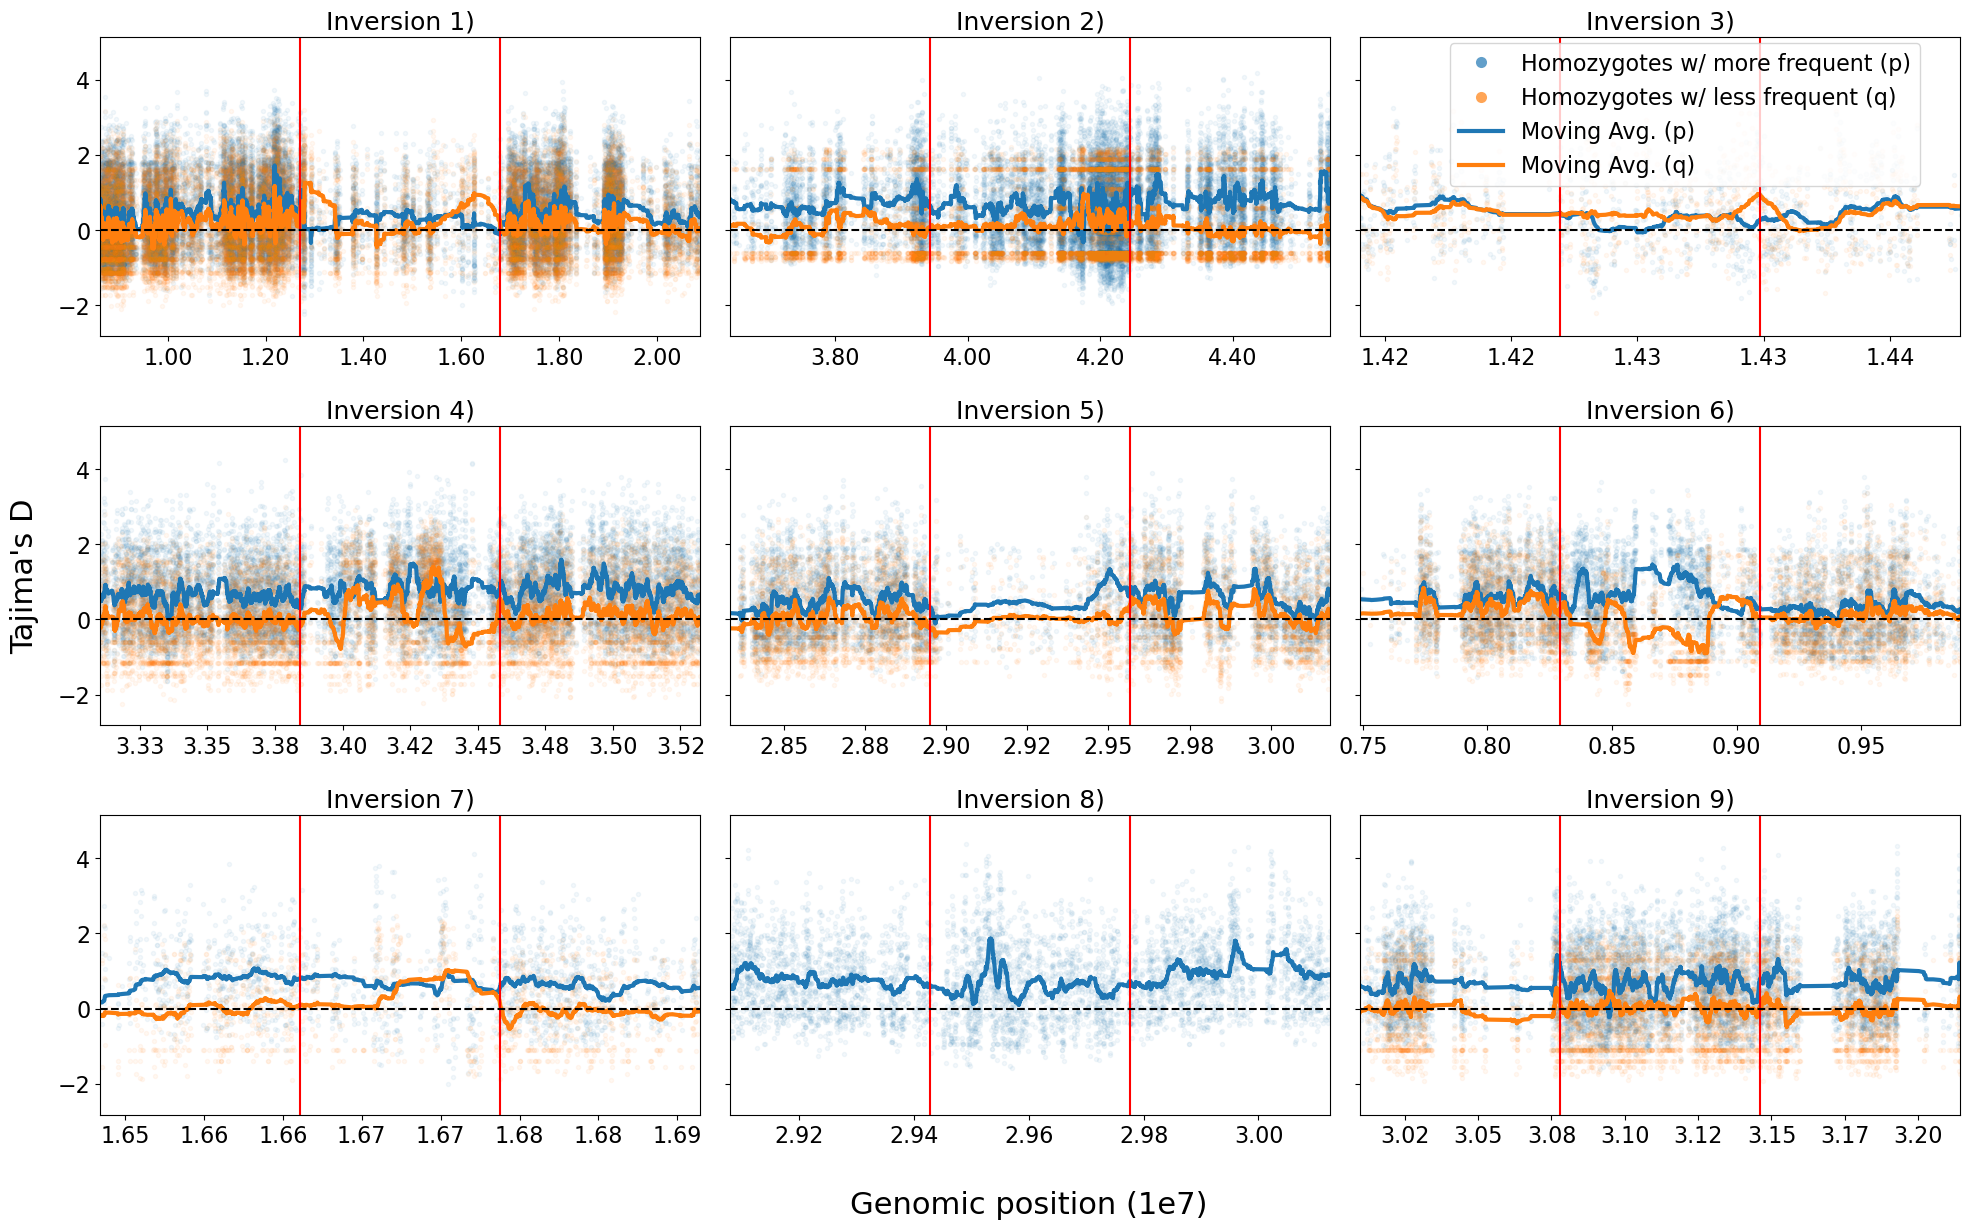

In [6]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

def scaled_formatter(val,pos):
    return f"{(val / scale_factor):.2f}"

proxy_scatter1 = plt.Line2D(
            [0], [0],
            marker='o',
            color='none',
            markerfacecolor='C0',
            markeredgecolor='none',
            alpha=0.7,
            markersize=8
        )
proxy_scatter2 = plt.Line2D(
            [0], [0],
            marker='o',
            color='none',
            markerfacecolor='C1',
            markeredgecolor='none',
            alpha=0.7,
            markersize=8
        )

all_chrs=["NW_022145594.1" ,"NW_022145594.1" ,"NW_022145597.1" ,"NW_022145600.1" ,"NW_022145601.1" ,"NW_022145603.1" ,"NW_022145606.1" ,"NW_022145609.1" ,"NW_022145610.1"]

starts=[12702886, 39429440, 14219351, 33842803, 28950395, 8291260, 16610900, 29427741, 30779143]
stops = [16793794 ,42445994 ,14298524 ,34582517 ,29566247 ,9094120 ,16737625 ,29776196 ,31460853]

f, axs = plt.subplots(3,3,figsize=(24, 14),sharex=False, sharey=True)

axs=axs.flatten()

counter=0
for c in all_chrs:

    dfp=pd.read_csv(f'nuc_div_data/{all_chrs[counter]}_{starts[counter]}_{stops[counter]}_nuc_div_homop.Tajima.D',sep="\t")
    dfq=pd.read_csv(f'nuc_div_data/{all_chrs[counter]}_{starts[counter]}_{stops[counter]}_nuc_div_homoq.Tajima.D',sep="\t")

    dfp = dfp.dropna()
    dfq = dfq.dropna()
    
    axs[counter].plot(dfp["BIN_START"],dfp["TajimaD"],".",color="C0",label="Homozygotes w/ more frequent (p)",alpha=0.05)
    if counter != 7:
        axs[counter].plot(dfq["BIN_START"],dfq["TajimaD"],".",color="C1",label="Homozygotes w/ less frequent (q)",alpha=0.05)

    #Moving average
    window_size = 100
    cumsum = np.cumsum(np.insert(np.array(dfp.TajimaD.to_list()), 0, 0))  # Cumulative sum
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    moving_avg = np.concatenate([np.full(window_size - 1, np.nan), moving_avg])
    axs[counter].plot(dfp["BIN_START"].to_list(), moving_avg, color='C0', linewidth=3, label=f'Moving Avg. (p)')
    if counter != 7:
        cumsum = np.cumsum(np.insert(np.array(dfq.TajimaD.to_list()), 0, 0))  # Cumulative sum
        moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
        moving_avg = np.concatenate([np.full(window_size - 1, np.nan), moving_avg])
        axs[counter].plot(dfq["BIN_START"].to_list(), moving_avg, color='C1', linewidth=3, label=f'Moving Avg. (q)')

    axs[counter].axvline(starts[counter], color="red")
    axs[counter].axvline(stops[counter], color="red")
    axs[counter].axhline(0, linestyle='--', color="black")

    offset=(stops[counter]-starts[counter]) * 1 #3_000_000
    axs[counter].set_xlim(starts[counter]-offset,stops[counter]+offset)
    
    axs[counter].set_title(f'Inversion {counter+1})', fontsize=18)
    axs[counter].tick_params(axis='both', which='major', labelsize=16)
    
    scale_factor = 1e7
    axs[counter].xaxis.set_major_formatter(FuncFormatter(scaled_formatter))

    if counter == 2:
        handles, labels = axs[counter].get_legend_handles_labels()
        new_handles = []
        for h, lbl in zip(handles, labels):
            if lbl == 'Homozygotes w/ more frequent (p)':
                new_handles.append(proxy_scatter1)   # Use our proxy for these points
            elif lbl == 'Homozygotes w/ less frequent (q)':
                new_handles.append(proxy_scatter2)
            else:
                new_handles.append(h)              # Keep everything else the same

        axs[counter].legend(new_handles, labels, loc=(0.15, 0.5), fontsize=16)

    counter+=1

plt.text(-0.15, 0.5, 'Tajima\'s D', va='center', rotation='vertical', fontsize=22, transform=axs[3].transAxes)
plt.text(0.2, -0.3, 'Genomic position (1e7)', va='center', rotation='horizontal', fontsize=22, transform=axs[7].transAxes)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.3)

plt.savefig(f'figs/all_tajima_plots.pdf', format='pdf', bbox_inches='tight')

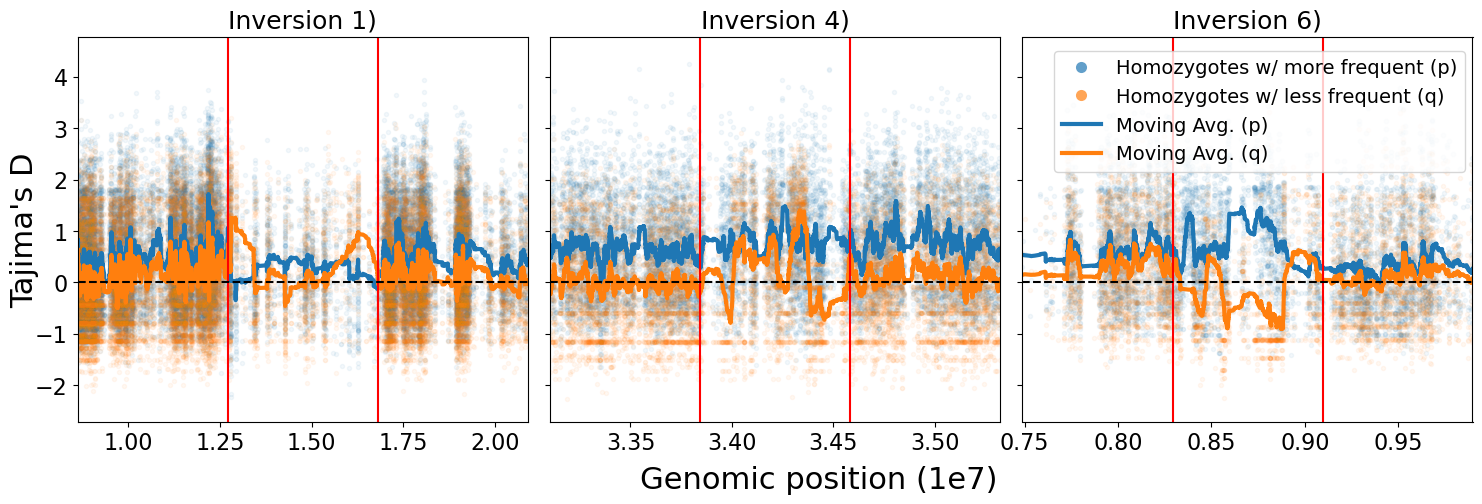

In [30]:
#ONLY SPECIFIC SUBPLOTS FROM ABOVE

all_chrs=["NW_022145594.1" ,"NW_022145600.1" ,"NW_022145603.1"]

starts=[12702886, 33842803, 8291260]
stops = [16793794 ,34582517,9094120]

f, axs = plt.subplots(1,3,figsize=(18, 5),sharex=False, sharey=True)

axs=axs.flatten()

counter=0
inv_labs = [1,4,6]
for c in all_chrs:

    dfp=pd.read_csv(f'nuc_div_data/{all_chrs[counter]}_{starts[counter]}_{stops[counter]}_nuc_div_homop.Tajima.D',sep="\t")
    dfq=pd.read_csv(f'nuc_div_data/{all_chrs[counter]}_{starts[counter]}_{stops[counter]}_nuc_div_homoq.Tajima.D',sep="\t")

    dfp = dfp.dropna()
    dfq = dfq.dropna()
    
    axs[counter].plot(dfp["BIN_START"],dfp["TajimaD"],".",color="C0",label="Homozygotes w/ more frequent (p)",alpha=0.05)
    if counter != 7:
        axs[counter].plot(dfq["BIN_START"],dfq["TajimaD"],".",color="C1",label="Homozygotes w/ less frequent (q)",alpha=0.05)

    #Moving average
    window_size = 100
    cumsum = np.cumsum(np.insert(np.array(dfp.TajimaD.to_list()), 0, 0))  # Cumulative sum
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    moving_avg = np.concatenate([np.full(window_size - 1, np.nan), moving_avg])
    axs[counter].plot(dfp["BIN_START"].to_list(), moving_avg, color='C0', linewidth=3, label=f'Moving Avg. (p)')
    if counter != 7:
        cumsum = np.cumsum(np.insert(np.array(dfq.TajimaD.to_list()), 0, 0))  # Cumulative sum
        moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
        moving_avg = np.concatenate([np.full(window_size - 1, np.nan), moving_avg])
        axs[counter].plot(dfq["BIN_START"].to_list(), moving_avg, color='C1', linewidth=3, label=f'Moving Avg. (q)')

    axs[counter].axvline(starts[counter], color="red")
    axs[counter].axvline(stops[counter], color="red")
    axs[counter].axhline(0, linestyle='--', color="black")

    offset=(stops[counter]-starts[counter]) * 1 #3_000_000
    axs[counter].set_xlim(starts[counter]-offset,stops[counter]+offset)
    
    axs[counter].set_title(f'Inversion {inv_labs[counter]})', fontsize=18)
    axs[counter].tick_params(axis='both', which='major', labelsize=16)
    
    scale_factor = 1e7
    axs[counter].xaxis.set_major_formatter(FuncFormatter(scaled_formatter))

    if counter == 2:
        handles, labels = axs[counter].get_legend_handles_labels()
        new_handles = []
        for h, lbl in zip(handles, labels):
            if lbl == 'Homozygotes w/ more frequent (p)':
                new_handles.append(proxy_scatter1)   # Use our proxy for these points
            elif lbl == 'Homozygotes w/ less frequent (q)':
                new_handles.append(proxy_scatter2)
            else:
                new_handles.append(h)              # Keep everything else the same

        axs[counter].legend(new_handles, labels, loc=(0.07, 0.65), fontsize=14)

    counter+=1

plt.text(-0.15, 0.5, 'Tajima\'s D', va='center', rotation='vertical', fontsize=22, transform=axs[0].transAxes)
plt.text(0.2, -0.15, 'Genomic position (1e7)', va='center', rotation='horizontal', fontsize=22, transform=axs[1].transAxes)

plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.3)

plt.savefig(f'figs/some_tajima.pdf', format='pdf', bbox_inches='tight')